Requirement: fsrs-optimizer >= 6.1.4

In [1]:
import numpy as np
import pandas as pd

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    0.4783,
    1.2172,
    9.7398,
    15.8796,
    6.8942,
    0.3659,
    3.2729,
    0.0099,
    1.4107,
    0.0061,
    0.5899,
    1.68,
    0.009,
    0.4049,
    1.2676,
    0.0,
    3.0064,
    0.3535,
    0.5764,
    0.2246,
    0.2205,
]


def generate_revlog_from_simulation(initial_parameters, learn_span, seed=2023):
    flattened_revlogs = []
    deck_size = 10000
    for i, r in enumerate([0.9]):
        _, _, _, _, _, revlogs = simulate(
            w=initial_parameters,
            request_retention=r,
            deck_size=deck_size,
            learn_span=learn_span,
            max_cost_perday=3600,
            learning_step_count=0,
            relearning_step_count=0,
            seed=seed,
            fuzz=True,
        )

        for day in revlogs:
            card_ids = revlogs[day]["card_id"]
            ratings = revlogs[day]["rating"]
            for card_id, rating in zip(card_ids, ratings):
                flattened_revlogs.append(
                    {
                        "card_id": card_id + i * deck_size,
                        "review_rating": int(rating),
                        "day": day,
                    }
                )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt

decay_list = []
trained_parameters = None


def train_and_evaluate(df):
    train_df, test_df = (
        df.iloc[: int(len(df) * 0.8)].copy(),
        df.iloc[int(len(df) * 0.8) :].copy(),
    )
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer(enable_short_term=False)
    optimizer.S0_dataset_group = (
        train_df[train_df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=train_df, verbose=False)
    optimizer.init_w[20] = initial_parameters[20]
    optimizer.train(gamma=0, verbose=False)
    global trained_parameters
    trained_parameters = optimizer.w
    decay_list.append(optimizer.w[20])
    # optimizer.dataset = test_df
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, trained_parameters):
        if param == 0 and trained_param == 0:
            continue
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset


def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 30
sample size: 5576


  0%|          | 0/4460 [00:00<?, ?it/s]

loss before: 0.3467, loss after: 0.3266
RMSE(bins): 0.0269
AUC: 0.5650
0.4783 -> 0.3652: SMAPE=26.8168%
1.2172 -> 1.4814: SMAPE=19.5805%
9.7398 -> 8.8155: SMAPE=9.9627%
15.8796 -> 12.9313: SMAPE=20.4666%
6.8942 -> 6.6883: SMAPE=3.0318%
0.3659 -> 0.7664: SMAPE=70.7410%
3.2729 -> 3.2981: SMAPE=0.7670%
0.0099 -> 0.001: SMAPE=163.3028%
1.4107 -> 1.5637: SMAPE=10.2878%
0.0061 -> 0.4013: SMAPE=194.0108%
0.5899 -> 0.5068: SMAPE=15.1546%
1.68 -> 1.6776: SMAPE=0.1430%
0.009 -> 0.0295: SMAPE=106.4935%
0.4049 -> 0.4845: SMAPE=17.8997%
1.2676 -> 1.9023: SMAPE=40.0454%
0.0 -> 0.1212: SMAPE=200.0000%
3.0064 -> 1.899: SMAPE=45.1502%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1: SMAPE=75.1950%
Avg. SMAPE: 72.7817%
loss before: 0.3467, loss after: 0.3262
RMSE(bins): 0.0259
AUC: 0.5774
--------------------------------
learn_span: 60
sample size: 12468


  0%|          | 0/9974 [00:00<?, ?it/s]

loss before: 0.3425, loss after: 0.3238
RMSE(bins): 0.0174
AUC: 0.5700
0.4783 -> 0.3567: SMAPE=29.1257%
1.2172 -> 1.3517: SMAPE=10.4714%
9.7398 -> 9.6561: SMAPE=0.8631%
15.8796 -> 12.52: SMAPE=23.6595%
6.8942 -> 6.4995: SMAPE=5.8938%
0.3659 -> 0.4582: SMAPE=22.4002%
3.2729 -> 3.5922: SMAPE=9.3021%
0.0099 -> 0.0057: SMAPE=53.8462%
1.4107 -> 1.627: SMAPE=14.2410%
0.0061 -> 0.2669: SMAPE=191.0623%
0.5899 -> 0.6182: SMAPE=4.6850%
1.68 -> 1.6607: SMAPE=1.1554%
0.009 -> 0.0515: SMAPE=140.4959%
0.4049 -> 0.4815: SMAPE=17.2834%
1.2676 -> 1.8922: SMAPE=39.5341%
3.0064 -> 2.2084: SMAPE=30.6052%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.105: SMAPE=70.9677%
Avg. SMAPE: 58.7479%
loss before: 0.3425, loss after: 0.3242
RMSE(bins): 0.0186
AUC: 0.5716
--------------------------------
learn_span: 120
sample size: 26598


  0%|          | 0/21278 [00:00<?, ?it/s]

loss before: 0.3396, loss after: 0.3249
RMSE(bins): 0.0163
AUC: 0.5587
0.4783 -> 0.3579: SMAPE=28.7969%
1.2172 -> 1.4815: SMAPE=19.5872%
9.7398 -> 10.7328: SMAPE=9.7008%
15.8796 -> 16.5595: SMAPE=4.1919%
6.8942 -> 6.485: SMAPE=6.1170%
0.3659 -> 0.3834: SMAPE=4.6710%
3.2729 -> 3.5103: SMAPE=6.9996%
0.0099 -> 0.0217: SMAPE=74.6835%
1.4107 -> 1.5719: SMAPE=10.8094%
0.0061 -> 0.1281: SMAPE=181.8182%
0.5899 -> 0.5835: SMAPE=1.0908%
1.68 -> 1.6072: SMAPE=4.4293%
0.009 -> 0.1261: SMAPE=173.3531%
0.4049 -> 0.4939: SMAPE=19.8042%
1.2676 -> 1.9281: SMAPE=41.3368%
0.0 -> 0.0001: SMAPE=200.0000%
3.0064 -> 2.3249: SMAPE=25.5660%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.101: SMAPE=74.3390%
Avg. SMAPE: 66.5077%
loss before: 0.3396, loss after: 0.3249
RMSE(bins): 0.0167
AUC: 0.5605
--------------------------------
learn_span: 240
sample size: 55632


  0%|          | 0/44505 [00:00<?, ?it/s]

loss before: 0.3398, loss after: 0.3262
RMSE(bins): 0.0120
AUC: 0.5549
0.4783 -> 0.3637: SMAPE=27.2209%
1.2172 -> 1.0837: SMAPE=11.6042%
9.7398 -> 11.0474: SMAPE=12.5808%
15.8796 -> 18.2589: SMAPE=13.9391%
6.8942 -> 6.4352: SMAPE=6.8870%
0.3659 -> 0.1694: SMAPE=73.4168%
3.2729 -> 3.4784: SMAPE=6.0877%
0.0099 -> 0.0095: SMAPE=4.1237%
1.4107 -> 1.4962: SMAPE=5.8826%
0.0061 -> 0.053: SMAPE=158.7140%
0.5899 -> 0.6006: SMAPE=1.7976%
1.68 -> 1.5955: SMAPE=5.1595%
0.009 -> 0.1162: SMAPE=171.2460%
0.4049 -> 0.4831: SMAPE=17.6126%
1.2676 -> 2.0098: SMAPE=45.2920%
0.0 -> 0.0009: SMAPE=200.0000%
3.0064 -> 2.6407: SMAPE=12.9518%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1161: SMAPE=62.0321%
Avg. SMAPE: 64.0912%
loss before: 0.3398, loss after: 0.3262
RMSE(bins): 0.0120
AUC: 0.5560
--------------------------------
learn_span: 480
sample size: 114872


  0%|          | 0/91897 [00:00<?, ?it/s]

loss before: 0.3382, loss after: 0.3267
RMSE(bins): 0.0103
AUC: 0.5471
0.4783 -> 0.3878: SMAPE=20.8983%
1.2172 -> 1.1868: SMAPE=2.5291%
9.7398 -> 11.0714: SMAPE=12.7970%
15.8796 -> 18.2443: SMAPE=13.8595%
6.8942 -> 6.3665: SMAPE=7.9589%
0.3659 -> 0.0414: SMAPE=159.3420%
3.2729 -> 3.3507: SMAPE=2.3492%
0.0099 -> 0.0098: SMAPE=1.0152%
1.4107 -> 1.3751: SMAPE=2.5558%
0.0061 -> 0.0234: SMAPE=117.2881%
0.5899 -> 0.6301: SMAPE=6.5902%
1.68 -> 1.7446: SMAPE=3.7727%
0.009 -> 0.0889: SMAPE=163.2278%
0.4049 -> 0.4316: SMAPE=6.3837%
1.2676 -> 2.3354: SMAPE=59.2728%
0.0 -> 0.0028: SMAPE=200.0000%
3.0064 -> 3.0021: SMAPE=0.1431%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1092: SMAPE=67.5159%
Avg. SMAPE: 64.6127%
loss before: 0.3382, loss after: 0.3266
RMSE(bins): 0.0099
AUC: 0.5481
--------------------------------
learn_span: 960
sample size: 179905


  0%|          | 0/143924 [00:00<?, ?it/s]

loss before: 0.3376, loss after: 0.3277
RMSE(bins): 0.0095
AUC: 0.5398
0.4783 -> 0.4009: SMAPE=17.6069%
1.2172 -> 1.159: SMAPE=4.8986%
9.7398 -> 11.6012: SMAPE=17.4444%
15.8796 -> 18.979: SMAPE=17.7827%
6.8942 -> 6.3654: SMAPE=7.9761%
0.3659 -> 0.0289: SMAPE=170.7194%
3.2729 -> 3.3169: SMAPE=1.3354%
0.0099 -> 0.0137: SMAPE=32.2034%
1.4107 -> 1.2846: SMAPE=9.3570%
0.0061 -> 0.0177: SMAPE=97.4790%
0.5899 -> 0.6879: SMAPE=15.3389%
1.68 -> 1.7662: SMAPE=5.0026%
0.009 -> 0.157: SMAPE=178.3133%
0.4049 -> 0.4196: SMAPE=3.5658%
1.2676 -> 2.9443: SMAPE=79.6173%
0.0 -> 0.006: SMAPE=200.0000%
3.0064 -> 3.0082: SMAPE=0.0599%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1124: SMAPE=64.9444%
Avg. SMAPE: 68.2386%
loss before: 0.3376, loss after: 0.3276
RMSE(bins): 0.0093
AUC: 0.5423
--------------------------------
learn_span: 1920
sample size: 246805


  0%|          | 0/197444 [00:00<?, ?it/s]

loss before: 0.3357, loss after: 0.3268
RMSE(bins): 0.0079
AUC: 0.5364
0.4783 -> 0.4064: SMAPE=16.2541%
1.2172 -> 1.1544: SMAPE=5.2960%
9.7398 -> 11.3835: SMAPE=15.5629%
15.8796 -> 19.3541: SMAPE=19.7226%
6.8942 -> 6.3731: SMAPE=7.8554%
0.3659 -> 0.0477: SMAPE=153.8685%
3.2729 -> 3.2747: SMAPE=0.0550%
0.0099 -> 0.0113: SMAPE=13.2075%
1.4107 -> 1.2664: SMAPE=10.7803%
0.0061 -> 0.0053: SMAPE=14.0351%
0.5899 -> 0.6999: SMAPE=17.0569%
1.68 -> 1.7178: SMAPE=2.2250%
0.009 -> 0.1622: SMAPE=178.9720%
0.4049 -> 0.4348: SMAPE=7.1216%
1.2676 -> 3.374: SMAPE=90.7618%
0.0 -> 0.0021: SMAPE=200.0000%
3.0064 -> 3.0503: SMAPE=1.4496%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1195: SMAPE=59.4118%
Avg. SMAPE: 63.0001%
loss before: 0.3357, loss after: 0.3267
RMSE(bins): 0.0075
AUC: 0.5383
--------------------------------


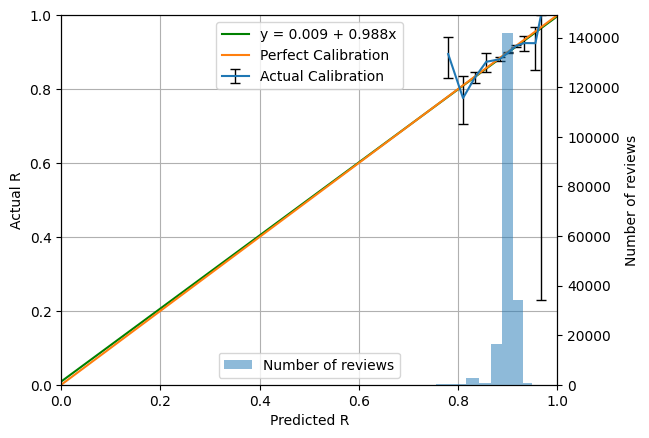

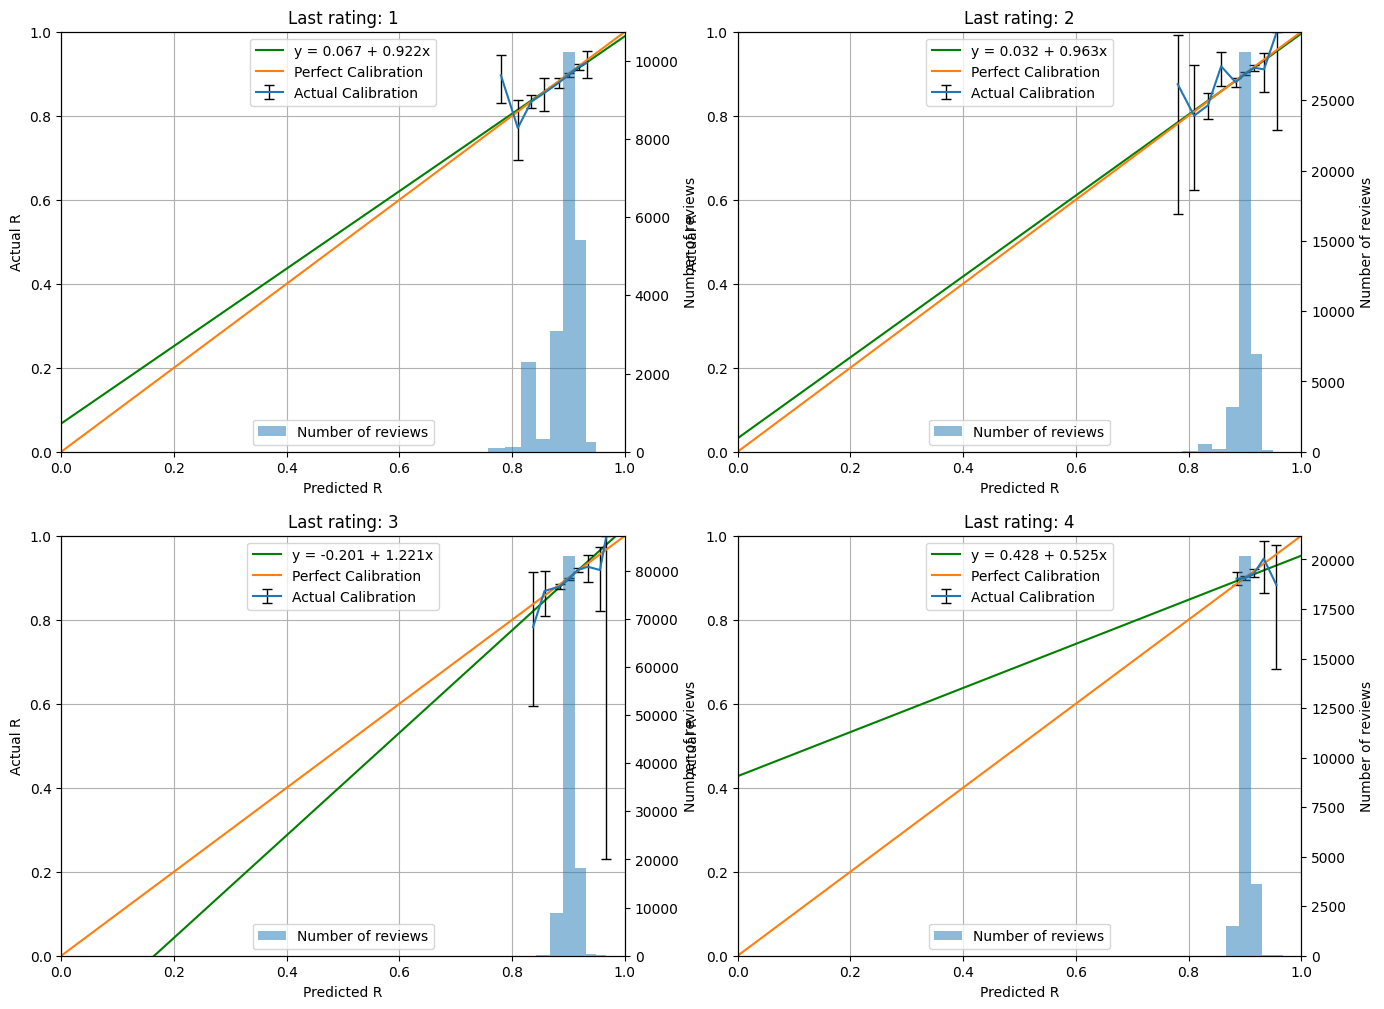

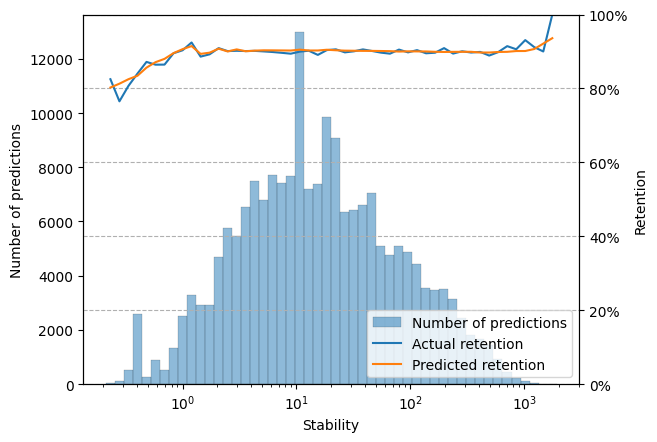

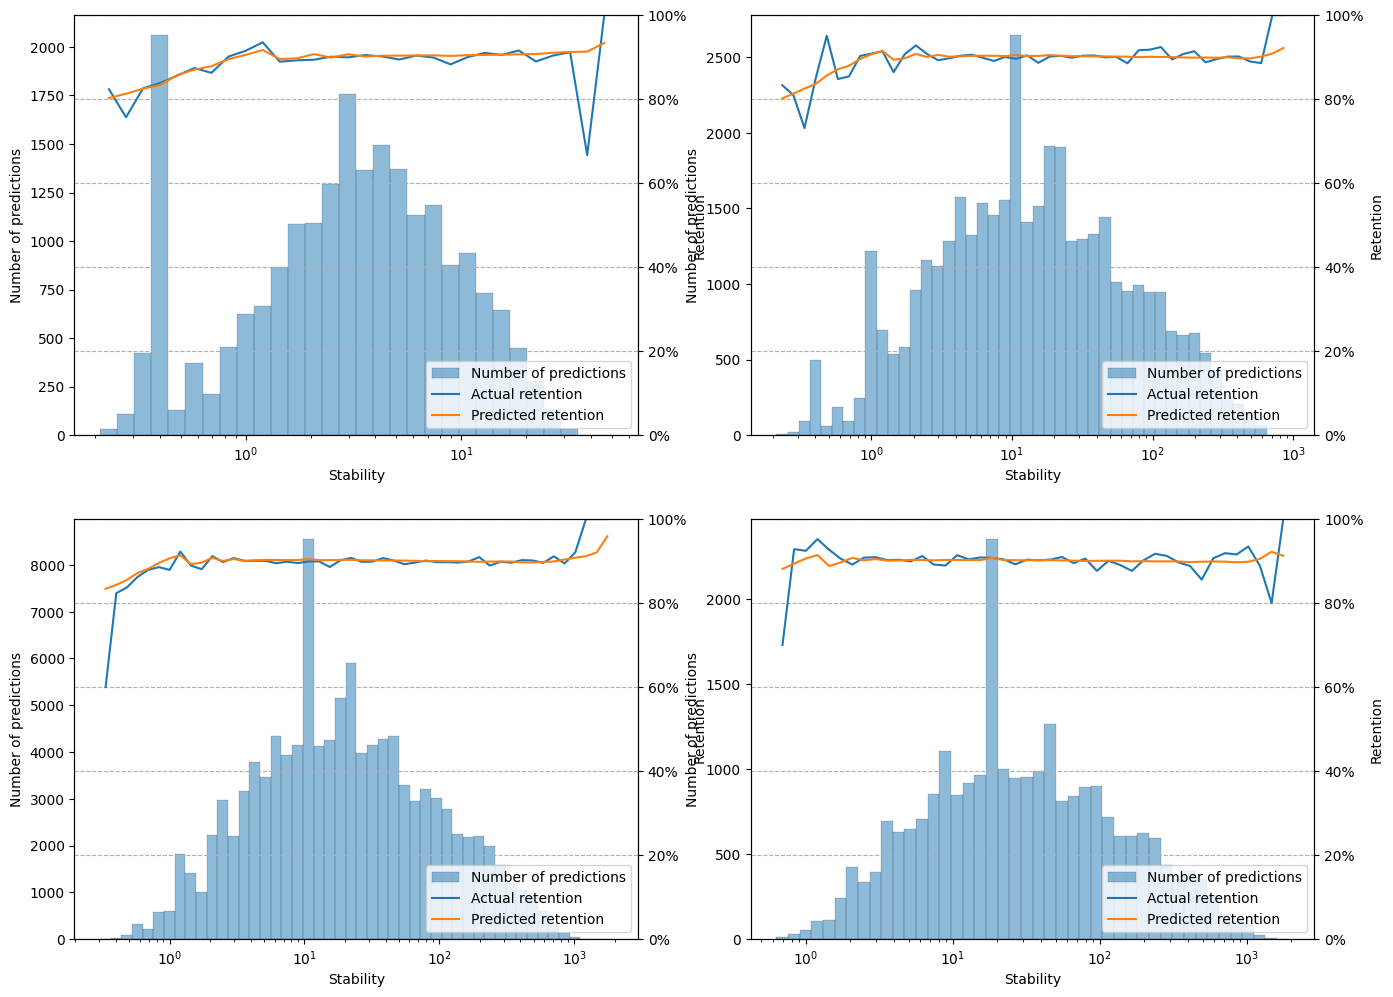

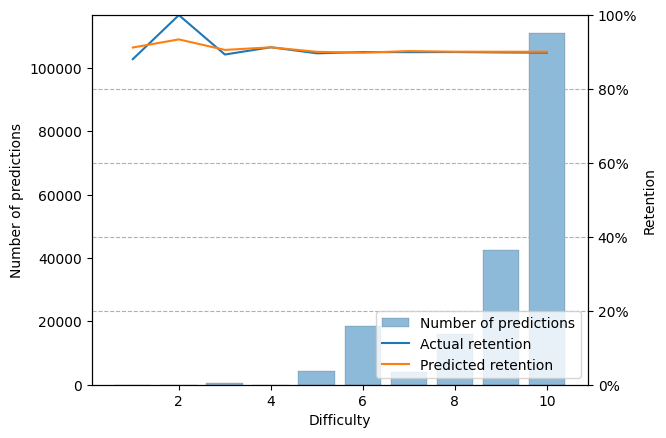

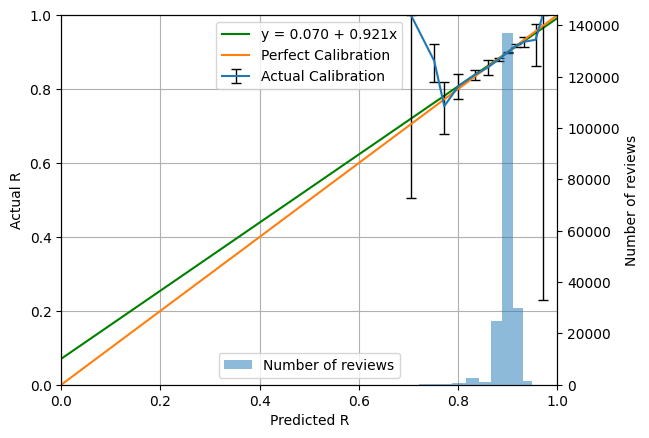

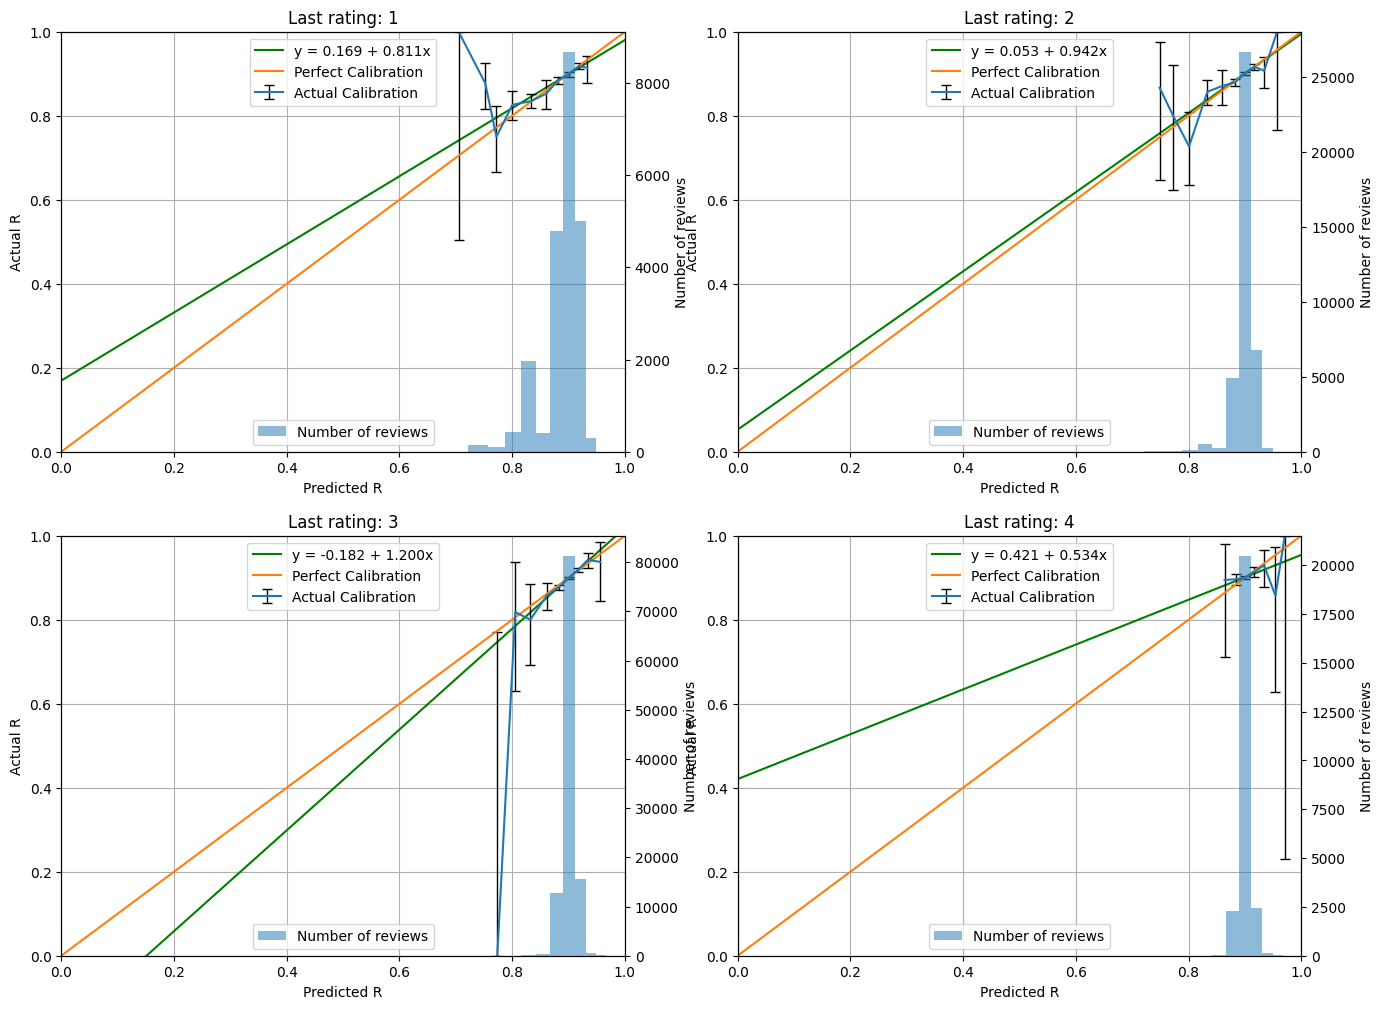

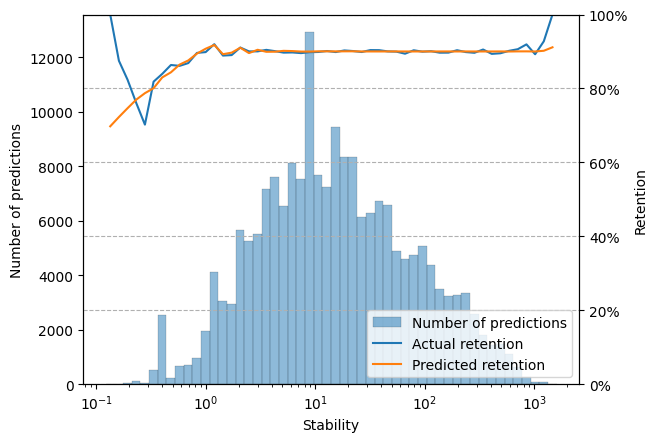

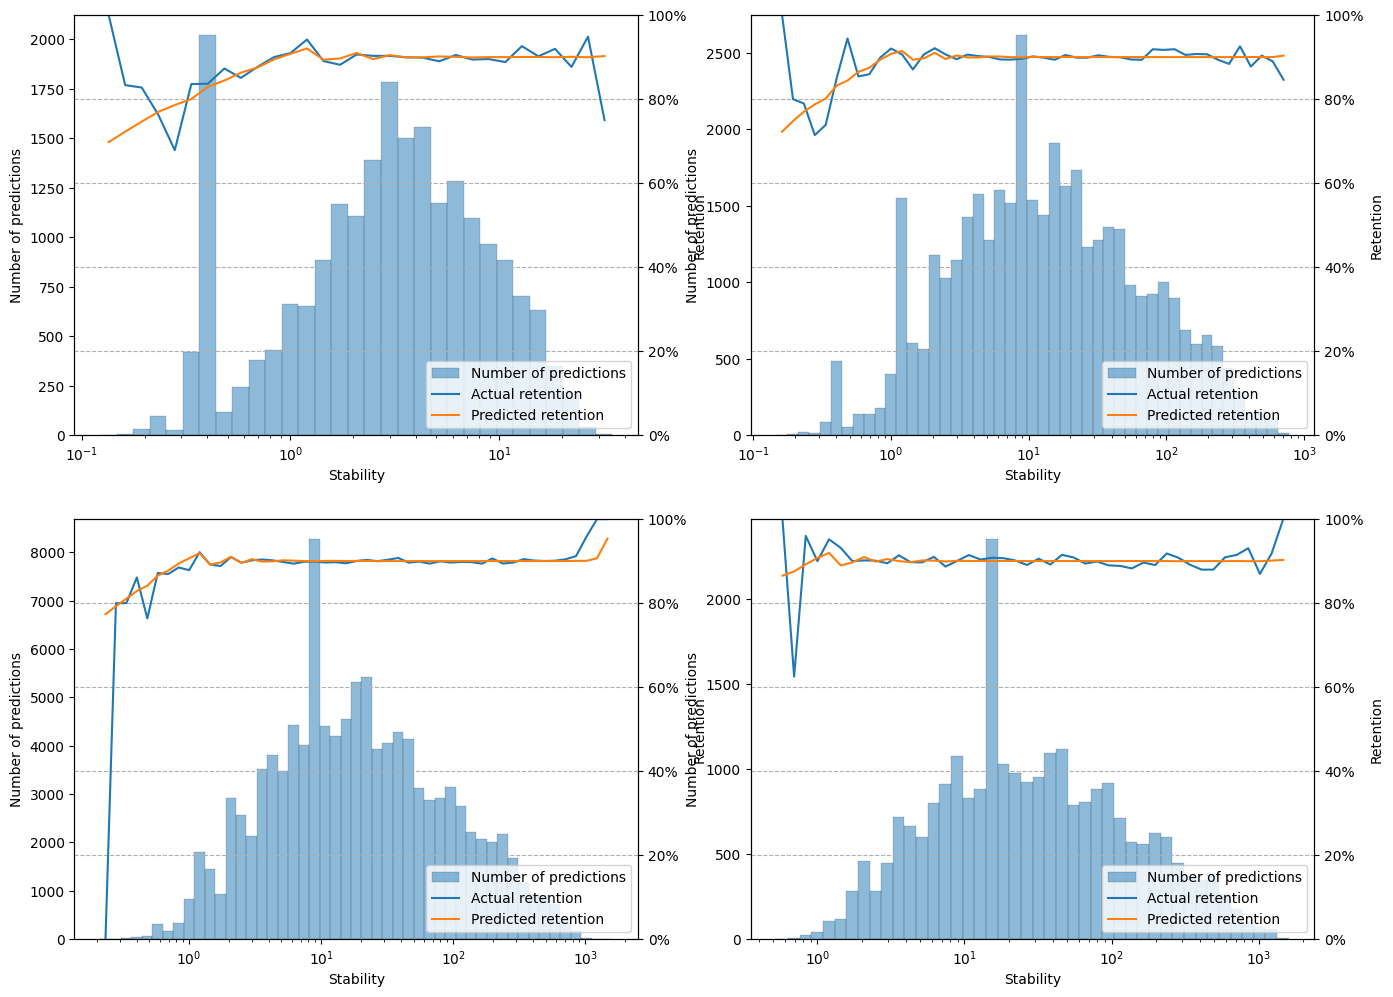

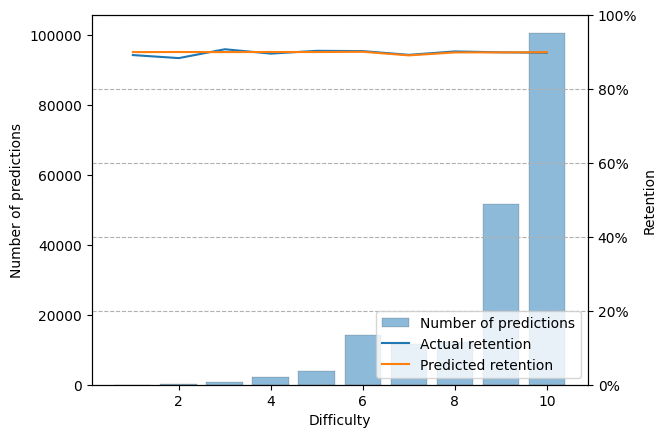

In [4]:
learn_span_list = [30, 60, 120, 240, 480, 960, 1920]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(
        initial_parameters, learn_span=learn_span, seed=2023
    )
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

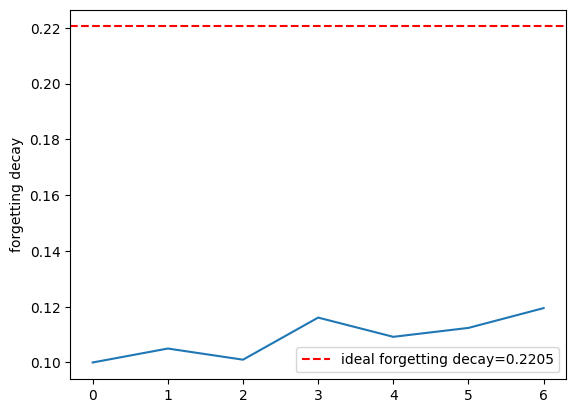

In [5]:
plt.plot(decay_list)
plt.axhline(y=initial_parameters[20], color='r', linestyle='--', label=f'ideal forgetting decay={initial_parameters[20]:.4f}')
plt.ylabel("forgetting decay")
plt.legend()
plt.show()

In [6]:
np.set_printoptions(precision=6, suppress=True)
print(
    f"logloss (trained - ideal): {np.array(logloss_list) - np.array(ideal_logloss_list)}"
)
print(
    f"RMSE(bins) (trained - ideal): {np.array(rmse_list) - np.array(ideal_rmse_list)}"
)
print(f"AUC (trained - ideal): {np.array(auc_list) - np.array(ideal_auc_list)}")

logloss (trained - ideal): [ 0.000358 -0.000343 -0.000034  0.000009  0.000049  0.000078  0.000088]
RMSE(bins) (trained - ideal): [ 0.000984 -0.001143 -0.000377  0.000027  0.000327  0.000198  0.000402]
AUC (trained - ideal): [-0.012383 -0.001611 -0.001763 -0.001101 -0.001081 -0.002512 -0.001922]


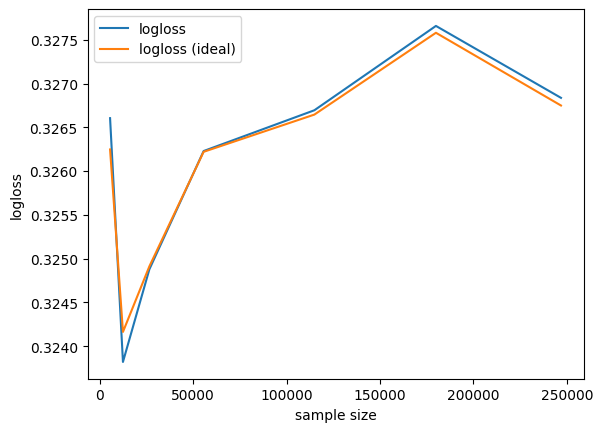

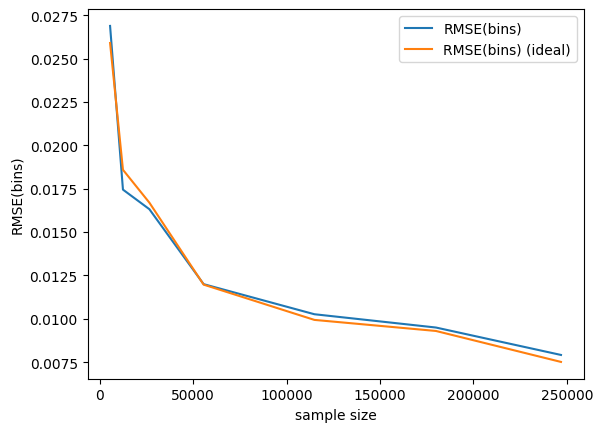

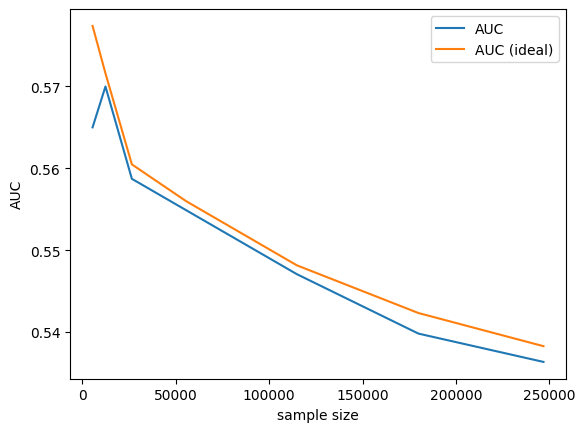

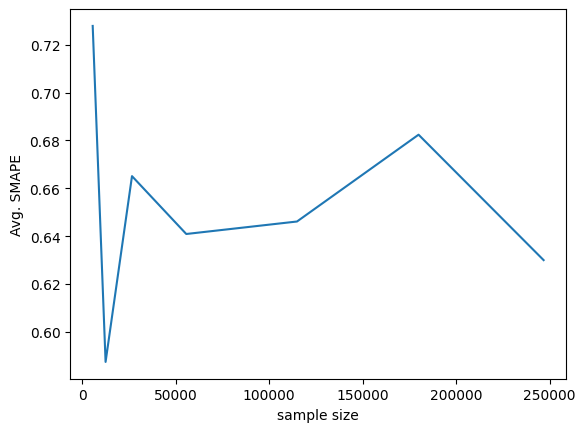

In [7]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()

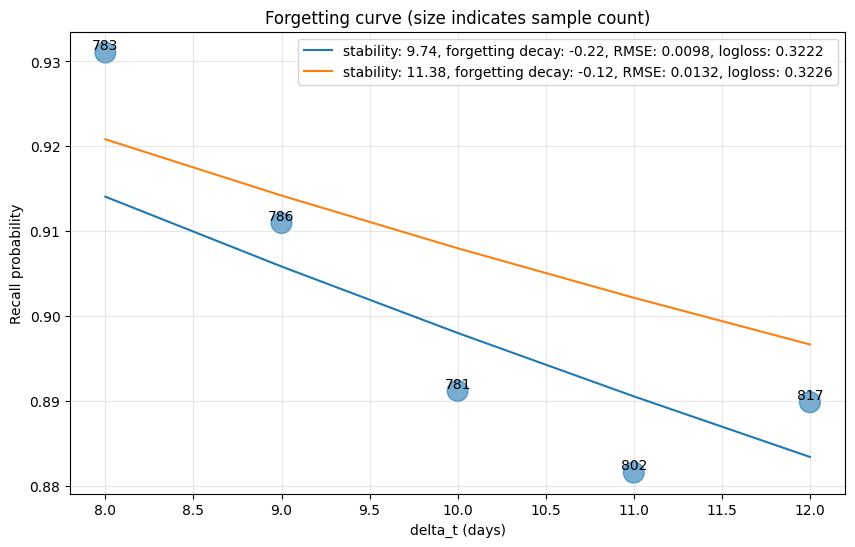

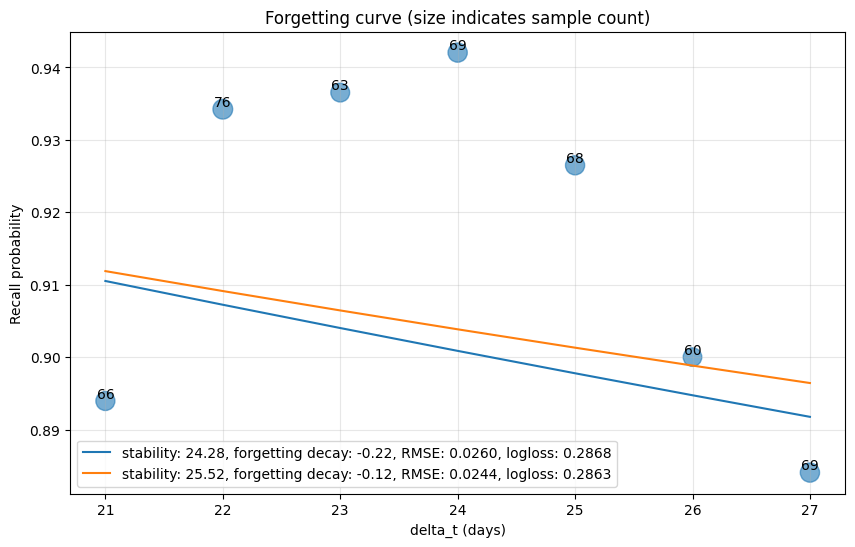

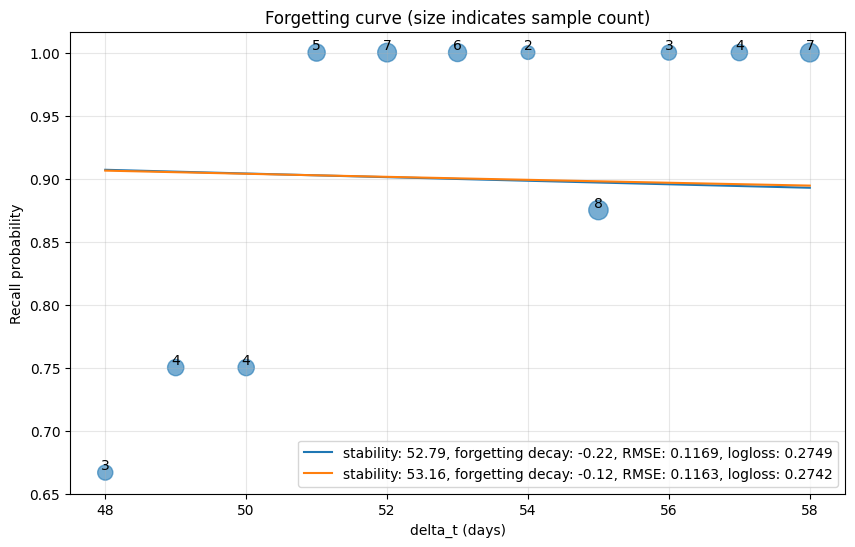

In [8]:
from fsrs_optimizer import power_forgetting_curve
from sklearn.metrics import root_mean_squared_error, log_loss

initial = Optimizer()
initial.dataset = dataset.copy()
initial.w = initial_parameters
loss_before, loss_after = initial.evaluate(save_to_file=False)
trained = Optimizer()
trained.dataset = dataset.copy()
trained.w = trained_parameters
loss_before, loss_after = trained.evaluate(save_to_file=False)
for r_history in ["3", "3,3", "3,3,3"]:
    t_history = df[df["r_history"] == r_history]["t_history"].value_counts().index[0]
    stabilities = []
    for df in [initial.dataset, trained.dataset]:
        tmp = df[(df["r_history"] == r_history) & (df["t_history"] == t_history)]
        points = tmp.groupby("delta_t")["y"].agg(["mean", "count"])
        stabilities.append(tmp["stability"].unique()[0])
    y_true = points["mean"]
    plt.figure(figsize=(10, 6))
    plt.scatter(
        points.index,
        y_true,
        s=np.sqrt(points["count"] / sum(points["count"])) * 500,
        alpha=0.6,
    )
    for x, y in zip(points.index, y_true):
        plt.text(x, y, points["count"][x], ha="center", va="bottom")

    for s, d in zip(stabilities, [initial_parameters[20], trained_parameters[20]]):
        y_pred = power_forgetting_curve(points.index, s, -d)
        rmse = root_mean_squared_error(y_true, y_pred, sample_weight=points["count"])
        logloss = log_loss(
            tmp["y"],
            power_forgetting_curve(tmp["delta_t"], s, -d),
        )
        plt.plot(
            points.index,
            y_pred,
            label=f"stability: {s:.2f}, forgetting decay: {-d:.2f}, RMSE: {rmse:.4f}, logloss: {logloss:.4f}",
        )
    plt.xlabel("delta_t (days)")
    plt.ylabel("Recall probability")
    plt.title("Forgetting curve (size indicates sample count)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [9]:
from fsrs_optimizer import FSRS
import torch


def calculate_retention(parameters, r_history, t_history, next_interval):
    """Calculate retention for given review history and parameters"""
    fsrs = FSRS(parameters)
    tensor = torch.tensor([t_history, r_history]).transpose(0, 1).unsqueeze(1)
    _, state = fsrs.forward(tensor)
    stability = state[0][0].item()
    retention = power_forgetting_curve(next_interval, stability, -parameters[20])
    print(next_interval, retention)


# Initial parameters
calculate_retention(initial_parameters, [3], [0], 30)
calculate_retention(initial_parameters, [3, 3], [0, 30], 145)

# Trained parameters
calculate_retention(trained_parameters, [3], [0], 30)
calculate_retention(trained_parameters, [3, 3], [0, 30], 145)


# Initial parameters
calculate_retention(initial_parameters, [3], [0], 15)
calculate_retention(initial_parameters, [3, 3], [0, 15], 40)

# Trained parameters
calculate_retention(trained_parameters, [3], [0], 15)
calculate_retention(trained_parameters, [3, 3], [0, 15], 40)

30 0.7915504103679721
145 0.7616836320342888
30 0.8305497696896165
145 0.7946777635648735
15 0.8637188083443708
40 0.866692434992662
15 0.8818265217577799
40 0.8753048255012581


In [10]:
from fsrs_optimizer import next_interval

s = 100
for dr in [0.9, 0.8, 0.7, 0.5]:
    print(f"stability: {s}, desired retention: {dr}")
    ivl = next_interval(s, dr, decay=-initial_parameters[20])
    true_retention = power_forgetting_curve(ivl, s, -initial_parameters[20])
    print(f"initial: {ivl}, true retention: {true_retention:.2f}")
    ivl = next_interval(s, dr, decay=-trained_parameters[20])
    true_retention = power_forgetting_curve(ivl, s, -initial_parameters[20])
    print(f"trained: {ivl}, true retention: {true_retention:.2f}")
    print()

stability: 100, desired retention: 0.9
initial: 100, true retention: 0.90
trained: 100, true retention: 0.90

stability: 100, desired retention: 0.8
initial: 286, true retention: 0.80
trained: 387, true retention: 0.76

stability: 100, desired retention: 0.7
initial: 660, true retention: 0.70
trained: 1327, true retention: 0.61

stability: 100, desired retention: 0.5
initial: 3622, true retention: 0.50
trained: 23282, true retention: 0.33

